# Deep Reinforcement Learning on Atari Games

Created by Paul Scott<br>
MSE Computer and Information Science<br>
University of Pennsylvania<br>

# References

* https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
* https://keras.io/examples/rl/deep_q_network_breakout/
* https://github.com/mgbellemare/Arcade-Learning-Environment
* https://github.com/kenjyoung/MinAtar
* https://arxiv.org/pdf/1509.06461.pdf

# Setup

### Download Required Packages

In [ ]:
%%capture
!git clone https://github.com/kenjyoung/MinAtar.git
%pip install ./MinAtar
%pip install --upgrade gym
%pip install ale-py
%pip install torchinfo
%pip install autorom[accept-rom-license]

### Download ROMs for ALE Environment

In [ ]:
!mkdir roms/
!yes | AutoROM -d roms/
!ale-import-roms roms/

### Imports

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from ale_py import ALEInterface
import matplotlib.pyplot as plt
from matplotlib import animation, colors
from collections import namedtuple, deque
from itertools import count
from IPython import display
import random
from PIL import Image
from torchinfo import summary
import numpy as np
import seaborn as sns
import gym

# use gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# configure matplotlib
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update(plt.rcParamsDefault)
plt.rc('animation', html='jshtml')

# Environment Setup

### Define Base Environment Class

In [16]:
class AbstractEnvironment():
  def __init__(self, num_actions, state_shape, cmap=None, aspect=None):
    self.num_actions = num_actions
    self.state_shape = state_shape
    self.num_channels = state_shape[1]
    self.cmap = cmap
    self.aspect = aspect
    self.crop = None

  def reset(self):
    pass

  def step(self, action, frame_skip=0):
    pass

  def game_over(self):
    pass
  
  def render(self):
    pass

### Define ALE Environment

In [17]:
class ALEEnvironment(AbstractEnvironment):
  def __init__(self, game, stack_size=4, stack_rgb=False, initial_action=None, initial_delay=0):
    self.env = ALEInterface()
    self.env.loadROM(game)
    self.env.setFloat('repeat_action_probability', 0)
    self.frame_stack = deque()
    self.action_space = self.env.getMinimalActionSet()
    self.stack_size = stack_size
    self.stack_rgb = stack_rgb
    self.initial_action = initial_action
    self.initial_delay = initial_delay
    num_channels = stack_size * (3 if stack_rgb else 1)
    super().__init__(len(self.action_space), (1, num_channels, 84, 84), aspect='auto')

  def reset(self):
    self.env.reset_game()
    for _ in range(self.initial_delay):
      self.env.act(self.action_space[self.initial_action])
    padding_size = self.num_channels - (3 if self.stack_rgb else 1)
    self.frame_stack = deque([torch.zeros((84, 84))] * padding_size + [frame for frame in self.get_frame()])
    return self.format_state(self.frame_stack)

  def step(self, action, frame_skip=0):
    lives = self.env.lives()
    reward = self.env.act(self.action_space[action])
    for _ in range(frame_skip):
      reward += self.env.act(self.action_space[action])
    self.frame_stack.popleft()
    if self.stack_rgb:
      self.frame_stack.popleft()
      self.frame_stack.popleft()
    self.frame_stack += [frame for frame in self.get_frame()]
    next_state = self.format_state(self.frame_stack)
    done = self.env.lives() != lives or self.env.game_over()
    return next_state, reward, done

  def game_over(self):
    return self.env.game_over()

  def render(self):
    return self.env.getScreenRGB()

  def format_state(self, state):
    return torch.stack(tuple(state)).unsqueeze(0).to(device)

  def get_frame(self, channel_first=True):
    if self.stack_rgb:
      screen = Image.fromarray(self.env.getScreenRGB())
    else:
      screen = Image.fromarray(self.env.getScreenGrayscale())
    if self.crop:
      screen = screen.crop(self.crop)
    screen = screen.resize((84, 84), Image.BILINEAR)
    screen = torch.Tensor(np.asarray(screen)) / 255.0
    if channel_first:
      if self.stack_rgb:
        screen = screen.permute(2, 0, 1)
      else:
        screen = screen.unsqueeze(0)
    return screen.float()

### Define MinAtar Environment

In [18]:
class MinAtarEnvironment(AbstractEnvironment):
  def __init__(self, game):
    self.env = gym.make(f'MinAtar/{game}')
    self.finished = False
    state_shape = self.format_state(self.env.render(mode='array')).shape
    cmap = sns.color_palette("cubehelix", state_shape[1])
    cmap.insert(0, (0, 0, 0))
    cmap = colors.ListedColormap(cmap)
    super().__init__(self.env.action_space.n, state_shape, cmap=cmap)

  def reset(self):
    self.finished = False
    return self.format_state(self.env.reset())

  def step(self, action, frame_skip=None):
    next_state, reward, done, _ = self.env.step(action)
    next_state = self.format_state(next_state)
    self.finished = done
    return next_state, reward, done

  def game_over(self):
    return self.finished

  def render(self):
    return np.amax(self.env.render(mode='array') * \
        np.reshape(np.arange(self.num_channels) + 1, (1, 1, -1)), 2) + 0.5

  def format_state(self, state):
    return torch.tensor(state, device=device).permute(2, 0, 1).unsqueeze(0).float()

### Select Environment

In [19]:
from ale_py.roms import Breakout
env = ALEEnvironment(Breakout, stack_size=2, initial_action=1, initial_delay=1)

# env = MinAtarEnvironment('Breakout-v1')

A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]
Game console created:
  ROM file:  /home/paulscott/anaconda3/lib/python3.9/site-packages/ale_py/roms/breakout.bin
  Cart Name: Breakout - Breakaway IV (1978) (Atari)
  Cart MD5:  f34f08e5eb96e500e851a80be3277a56
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is 1654610605


### Crop and Preview Game
(ALE only)

| Game | Crop |
| ---- | ---- |
| Breakout | (8, 94, width - 8, height - 16) |
| Kaboom | (8, 52, width - 8, height - 22) |
| Ms. Pacman | (4, 2, width - 4, height - 40) |
| Skiing | (8, 24, width - 8, height - 24)|

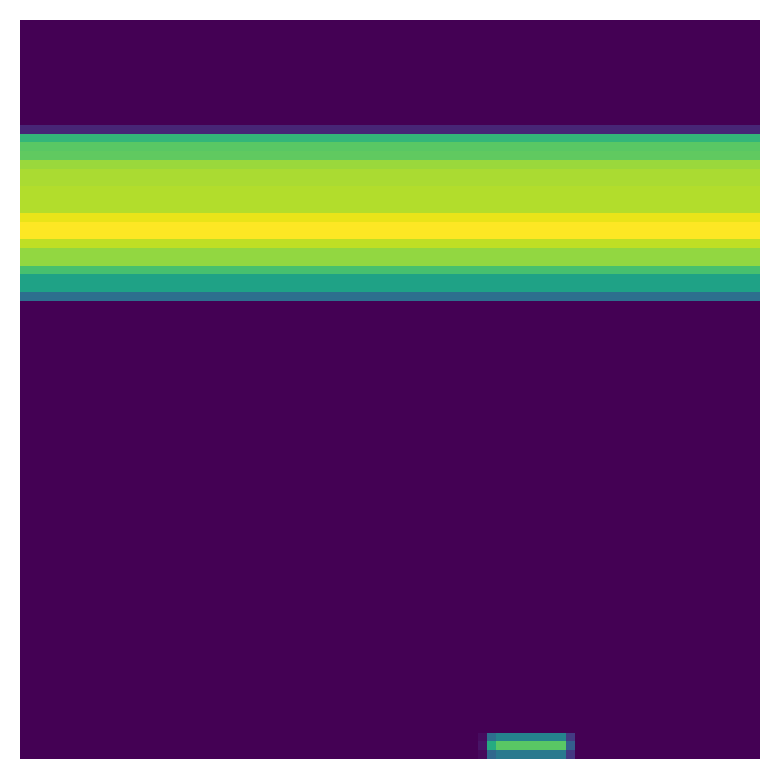

In [20]:
if isinstance(env, ALEEnvironment):
  width = env.env.getScreenDims()[1]
  height =  env.env.getScreenDims()[0]
  env.crop = (8, 32, width - 8, height - 16)

  plt.imshow(env.get_frame(channel_first=False))
  plt.axis('off')
  plt.show()

# Agent Setup

### Define ALE DQN

In [21]:
class ALEDQN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(env.num_channels, 32, 8, stride=4)
    self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
    self.conv3 = nn.Conv2d(64, 64, 3, stride=1)
    self.fc1 = nn.Linear(64*7*7, 512)
    self.fc2 = nn.Linear(512, env.num_actions)

  def forward(self, x):
    # 3x84x84
    x = F.relu(self.conv1(x))
    
    # 32x20x20
    x = F.relu(self.conv2(x))

    # 64x9x9
    x = F.relu(self.conv3(x))

    # 64x7x7
    x = F.relu(self.fc1(x.flatten(start_dim=1)))
    x = self.fc2(x)

    return x

### Define MinAtar DQN

In [22]:
class MinAtarDQN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(env.num_channels, 32, 3, padding='same')
    self.conv2 = nn.Conv2d(32, 64, 3, padding='same')
    self.fc1 = nn.Linear(64*2*2, 512)
    self.fc2 = nn.Linear(512, env.num_actions)
    self.maxpool = nn.MaxPool2d(2, 2)

  def forward(self, x):
    # 4x10x10
    x = F.relu(self.conv1(x))
    x = self.maxpool(x)
    
    # 32x5x5
    x = F.relu(self.conv2(x))
    x = self.maxpool(x)

    # 64x2x2
    x = F.relu(self.fc1(x.flatten(start_dim=1)))
    x = self.fc2(x)

    return x

### Select DQN

In [23]:
dqn_class = ALEDQN if isinstance(env, ALEEnvironment) else MinAtarDQN
summary(dqn_class(), input_shape=env.state_shape)

Layer (type:depth-idx)                   Param #
ALEDQN                                   --
├─Conv2d: 1-1                            4,128
├─Conv2d: 1-2                            32,832
├─Conv2d: 1-3                            36,928
├─Linear: 1-4                            1,606,144
├─Linear: 1-5                            2,052
Total params: 1,682,084
Trainable params: 1,682,084
Non-trainable params: 0

# Training

Double DQN target Q-values:<br>
$Y_t = R_{t+1}+\gamma Q_{target}(S_{t+1}, argmax_a Q(S_{t+1}, a))$

### Define Training Functions

In [26]:
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state'))

class ReplayMemory(object):
  def __init__(self, size):
    self.memory = deque([], maxlen=size)

  def push(self, *args):
    self.memory.append(Transition(*args))

  def sample(self, batch_size):
    return random.sample(self.memory, batch_size)

  def __len__(self):
    return len(self.memory)


def train_dqn():
  global dqn, dqn_target, optimizer, replay_memory, batch_size

  if len(replay_memory) < batch_size:
    return

  # sample replay memory
  states, actions, rewards, next_states, final_indices = sample_replay_memory()

  # get q values from primary dqn
  q_values = dqn(states).gather(1, actions)

  # use double dqn or regular dqn
  expected_q_values = get_expected_q_values(rewards, next_states, final_indices)

  # calculate loss
  loss = criterion(q_values, expected_q_values)

  # update network
  optimizer.zero_grad()
  loss.backward()
  for param in dqn.parameters():
    param.grad.data.clamp_(-1, 1)
  optimizer.step()


def sample_replay_memory():
  global batch_size

  # get batch of transitions from replay memory
  transitions = replay_memory.sample(batch_size)
  transition_batch = Transition(*zip(*transitions))

  # get next states that are not final states
  final_indices = torch.tensor([next_state is None for next_state in transition_batch.next_state])

  # separate transitions batch by state, action, reward
  states = torch.cat(transition_batch.state)
  actions = torch.cat(transition_batch.action)
  rewards = torch.cat(transition_batch.reward)
  next_states = torch.cat([next_state for next_state in transition_batch.next_state if next_state is not None])

  return states, actions, rewards, next_states, final_indices


def get_expected_q_values(rewards, next_states, final_indices):
  global dqn, dqn_target, batch_size

  # get best actions for next state using primary dqn
  best_actions = dqn(next_states).max(1)[1].unsqueeze(1)

  # calculate future rewards using target dqn using above actions
  future_rewards = torch.zeros((batch_size, 1), device=device)
  future_rewards[~final_indices] = dqn_target(next_states).gather(1, best_actions)

  # get current q values and calculate expected q values
  expected_q_values = rewards.unsqueeze(1) + (gamma * future_rewards)
  expected_q_values[final_indices] = -1.0

  return expected_q_values


def select_action(state):
  global epsilon, epsilon_start, epsilon_end, epsilon_random_frames, epsilon_greedy_frames, steps, dqn
  if steps < epsilon_random_frames or epsilon > random.random():
    action = torch.tensor([[random.randrange(env.num_actions)]], device=device, dtype=torch.long)
  else:
     with torch.no_grad():
      action = dqn(state).max(1)[1].view(1, 1)
  steps += 1
  if steps >= epsilon_random_frames:
    epsilon = epsilon_end + (epsilon_start - epsilon_end) / np.exp((steps - epsilon_random_frames) / epsilon_greedy_frames)
  return action


def plot_stats():
  global epsilon, episode_rewards, running_rewards, steps, steps_per_plot_update

  display.clear_output(wait=True)
  plt.title('Episode Rewards')
  plt.xlabel('Episode')
  plt.ylabel('Reward')
  plt.plot(range(1, len(episode_rewards) + 1), episode_rewards, 'o', markersize=2)
  plt.plot(range(1, len(running_rewards) * steps_per_plot_update + 1, steps_per_plot_update), running_rewards)
  plt.show()
  
  print(f'Episodes: {len(episode_rewards)} | Steps: {steps} | Max Reward: {max(episode_rewards)} | Running Reward: {round(running_rewards[-1], 2)} | Epsilon: {round(epsilon, 4)}')

### Define Training Settings

In [13]:
max_running_reward = 60
batch_size = 32
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.0
epsilon_random_frames = 50000
epsilon_greedy_frames = 3000000
replay_memory_size = 100000
frame_skip = 8
steps_per_target_update = 10000
steps_per_dqn_update = 4
steps_per_plot_update = 500

### Train Agent

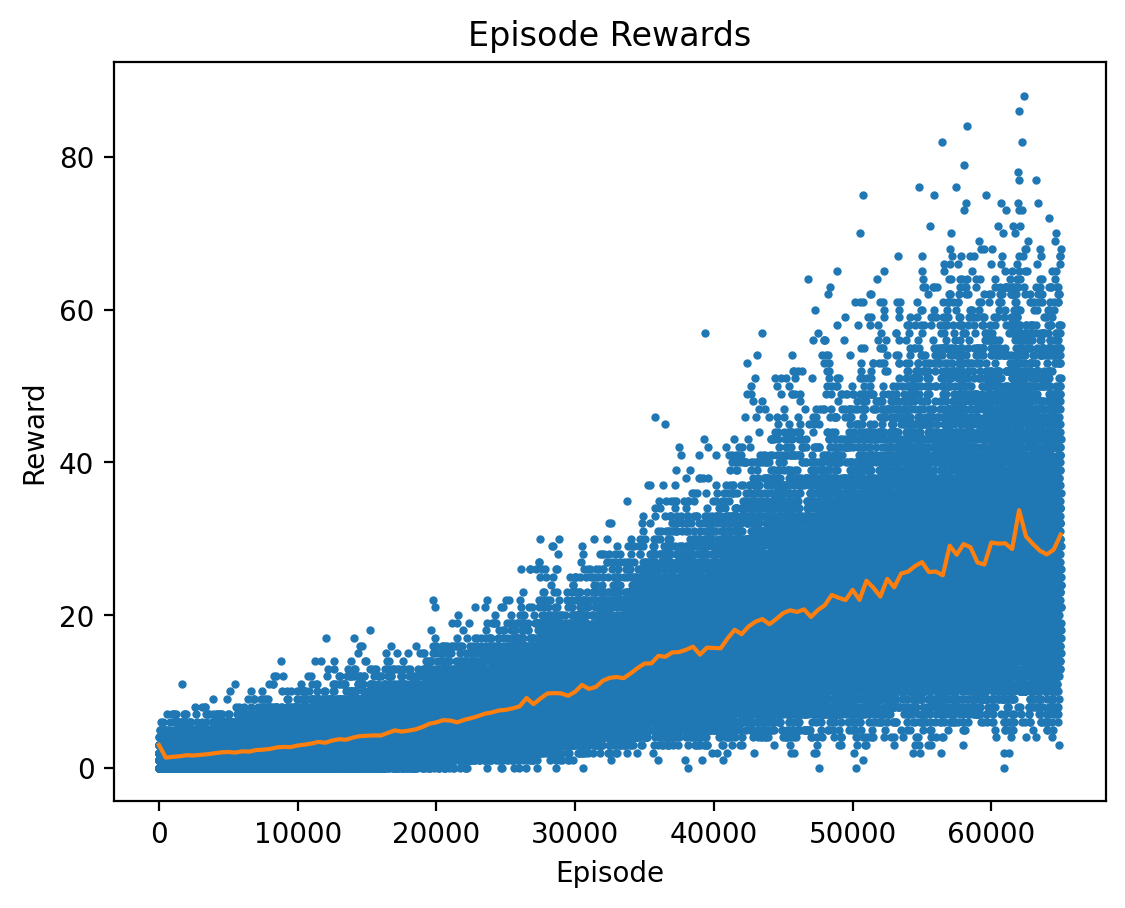

Episodes: 65001 | Steps: 18610133 | Max Reward: 88 | Running Reward: 30.55 | Epsilon: 0.0021


KeyboardInterrupt: 

In [14]:
# initialize dqn and target dqn
dqn = dqn_class().to(device)
dqn_target = dqn_class().to(device)
dqn_target.load_state_dict(dqn.state_dict())

# initialize replay memory and training loss and optimizer
replay_memory = ReplayMemory(replay_memory_size)
criterion = nn.HuberLoss()
optimizer = Adam(dqn.parameters(), lr=0.00025)

steps = 0
epsilon = epsilon_start
episode_rewards, running_rewards = [], []

for episode in count():
  state = env.reset()
  total_reward = 0

  for t in count(): 
    # select action using epsilon greedy strategy
    action = select_action(state)

    # perform action and get reward
    next_state, reward, done = env.step(action, frame_skip)
    total_reward += reward

    # add to replay memory
    reward = torch.tensor([reward], device=device)
    replay_memory.push(state, action, reward, None if done else next_state)
    state = next_state

    # train dqn on data saved to replay memory
    if steps % steps_per_dqn_update == 0:
      train_dqn()

    # update target dqn with weights from main dqn
    if steps % steps_per_plot_update == 0:
      dqn_target.load_state_dict(dqn.state_dict())
    
    # check if game is over
    if env.game_over():
      episode_rewards.append(total_reward)
      if len(running_rewards) == 0:
        running_rewards.append(total_reward)
      elif episode % steps_per_plot_update == 0:
        running_rewards.append(np.mean(episode_rewards[episode-steps_per_plot_update:episode]))
      if episode % steps_per_plot_update == 0:
        plot_stats()
      break

  # stop training once max score is reached
  if running_rewards[-1] >= max_running_reward:
    plot_stats()
    break

### Save Trained Agent

In [ ]:
torch.save(dqn.state_dict(), 'saved_models/mspacman_dqn.pt')
torch.save(dqn_target.state_dict(), 'saved_models/mspacman_target.pt')

# Results

### Load Trained Agent

In [ ]:
dqn = dqn_class(env).to(device)
dqn_target = dqn_class(env).to(device)

dqn.load_state_dict(torch.load('saved_models/mspacman_dqn.pt'))
dqn_target.load_state_dict(torch.load('saved_models/mspacman_dqn_target.pt'))

### Run Game With Trained Agent

In [ ]:
final_score = 20

total_reward = 0
reward_history = []
while total_reward < final_score:
  state = env.reset()
  total_reward = 0
  frames = [env.render()]

  for t in count():
    if random.random() > 0.02:
      action = dqn(state).max(1)[1].view(1, 1)
    else:
      torch.tensor([[random.randrange(env.num_actions)]], device=device, dtype=torch.long)
    state, reward, done = env.step(action, frame_skip)
    total_reward += reward
    
    frames.append(env.render())
    
    if done or total_reward >= final_score:
      reward_history.append(total_reward)
      print(f'\rEpisodes: {len(reward_history)} | Max Score: {max(reward_history)}', end='')
      break

### Visualize Gameplay

In [ ]:
fig, ax = plt.subplots()
fig.tight_layout(pad=0)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.axis('off')

def get_frame(index):
  ax.clear()
  return ax.imshow(frames[index], aspect=env.aspect, cmap=env.cmap)

plt.close()
gameplay = animation.FuncAnimation(fig, get_frame, frames=len(frames), interval=50)
gameplay

### Save Gameplay as GIF

In [ ]:
gameplay.save('pong.gif', writer='ffmpeg', fps=30)